# Analyze Model

How well does our trained model perform on unseen data? 

In [2]:
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
from scipy import stats

import os

# Plot Loss Curves

Load the (directory of) losses

In [4]:
loss_dir = 'Feburary 28th, 2024'
loss_files = os.listdir(f'loss/{loss_dir}')

In [5]:
loss_files

['loss_gruRNN_Feb28_1349.csv',
 'loss_gruRNN_Feb28_1996.csv',
 'loss_gruRNN_Feb28_2229.csv',
 'loss_gruRNN_Feb28_3158.csv',
 'loss_gruRNN_Feb28_3656.csv',
 'loss_gruRNN_Feb28_4931.csv',
 'loss_gruRNN_Feb28_5286.csv',
 'loss_gruRNN_Feb28_5718.csv',
 'loss_gruRNN_Feb28_7094.csv',
 'loss_gruRNN_Feb28_7954.csv',
 'loss_gruRNN_Feb28_8011.csv',
 'loss_gruRNN_Feb28_8458.csv',
 'loss_gruRNN_Feb28_8461.csv',
 'loss_gruRNN_Feb28_9018.csv',
 'loss_gruRNN_Feb28_9200.csv',
 'loss_gruRNN_Feb28_9998.csv']

Load each loss curve, also keeping track of the particular instance

In [8]:
losses = {}
for loss in loss_files:
    with open(f'loss/{loss_dir}/{loss}', 'rb') as f:
        temp = pd.read_csv(f)
    losses[loss] = temp

In [10]:
losses

{'loss_gruRNN_Feb28_1349.csv':      Unnamed: 0      loss  val_loss            lr
 0             0  0.002740  0.001176  1.000000e-03
 1             1  0.001313  0.000978  1.000000e-03
 2             2  0.001091  0.001200  1.000000e-03
 3             3  0.000897  0.001001  1.000000e-03
 4             4  0.000787  0.000810  1.000000e-03
 ..          ...       ...       ...           ...
 995         995  0.000190  0.000374  1.000000e-07
 996         996  0.000190  0.000375  1.000000e-07
 997         997  0.000190  0.000375  1.000000e-07
 998         998  0.000190  0.000375  1.000000e-07
 999         999  0.000190  0.000375  1.000000e-07
 
 [1000 rows x 4 columns],
 'loss_gruRNN_Feb28_1996.csv':      Unnamed: 0      loss  val_loss            lr
 0             0  0.002945  0.001019  1.000000e-03
 1             1  0.001356  0.001149  1.000000e-03
 2             2  0.001168  0.000815  1.000000e-03
 3             3  0.001039  0.000839  1.000000e-03
 4             4  0.000878  0.001193  1.00000

Store the validation loss to quantify performance ... which one did the best? 

In [27]:
train_mse = {}
test_mse = {}

for loss in loss_files:
    train_mse[loss]=np.sqrt(losses[loss]['loss'][999])
    test_mse[loss]=np.sqrt(losses[loss]['val_loss'][999])
    
    
# What is the 'best performing' model?
    
print(np.argmin(test_mse.values()))
print(np.argmin(train_mse.values()))

print(train_mse['loss_gruRNN_Feb28_1349.csv'])
print(test_mse['loss_gruRNN_Feb28_1349.csv'])
    

0
0
0.013781546721464177
0.01936048270730614


Factoring in the Feburary 28 loss curves, this takes into account the variables 'solar_radiation', 'temperature', 'CN^2', 'Relative Humidity' ... maybe make a scatter plot? 

Text(0, 0.5, 'RMSE')

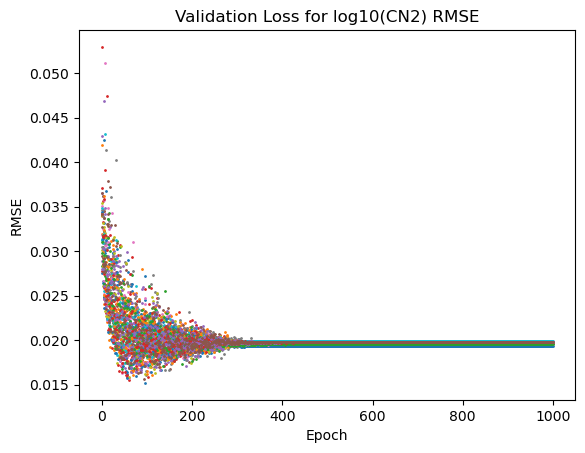

In [44]:
colors = np.arange(1000)
epochs = np.arange(1000)

for ii, loss in enumerate(loss_files):
    y = np.sqrt(losses[loss]['val_loss'][:])
    plt.scatter(epochs, y, s=1)
    
plt.title('Validation Loss for log10(CN2) RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

# Testing Model Predictions

Choose input features

In [48]:
input_features = ['solar_radiation', 'relative_humidity', 'CN2', 'temperature']

Load the data

In [58]:
# Some useful functions

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data(x):
    for ii in range(len(x)):
        x[ii] = (x[ii] - np.min(x))/(np.max(x) - np.min(x))
    return x

# This applies a rolling average on the dataset 

# Function taken from a learnpython article

def roll_average(input_data, window_size):
    result = []
    for i in range(len(input_data) - window_size + 1):
        window = input_data[i:i+window_size]
        window_average = sum(window)/window_size
        result.append(window_average)
        
    return np.array(result)
    
def rollify_training(X, window_size):
    X_features = X.shape[2]
    
    X_roll_len = X.shape[1] - window_size + 1
    
    X_roll = np.empty((len(X), X_roll_len, X_features))
    
    for ii in range(len(X)):
        for jj in range(X_features):
            X_roll[ii,:,jj] = roll_average(X[ii,:,jj], window_size)
            
    return X_roll


def load_data(direc_name, time_steps, input_list, window_size):

    total_input = []
    total_output = []
    
    # Files expected
    
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    num_features = len(input_list)
    
    print(f'Parameter List: {input_list}')
    
    
    for ii, name in enumerate(directory_list):

        df = pd.read_csv(f'{direc_name}/{name}')
    
        dataset_weather = np.empty((time_steps, num_features))  
        dataset_output = np.empty((1, 1))
        
        ###### INPUT DATA #######
        
        for ii, colName in enumerate(input_list):
            if(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName].to_numpy())
            else:
                dataset_weather[:,ii] = df[colName].to_numpy()
            
        total_input.append(dataset_weather)
        
        ###### OUTPUT DATA #######
        
        
        # In the 0th output, CN2 FUTURE
        dataset_output[:,0] = np.log10(eval(df["CN2-R0 Future"][1]))

        total_output.append(dataset_output)
        
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    # Apply rolling average onto the input data
    total_input = rollify_training(total_input, window_size)
    
    
    # Apply normalization to each input entry
    for ii in range(num_features):
        total_input[:,:,ii] = norm_data(total_input[:,:,ii])
        
        
    # Apply normalization to each output entry
    total_output[:,:,0] = norm_data(total_output[:,:,0])

    return total_input, total_output

direc_name = "Batched Data/oneHourAhead24Fall" # yaml worthy
sizeOfFiles = len([name for name in os.listdir(f'{direc_name}/.')]) # Global parameter

print(f"Number of files:{sizeOfFiles}")
train_factor = 0.90
num_of_examples = int(sizeOfFiles*train_factor)
X, y = load_data(direc_name, 24, input_features, 3)
X_train, y_train = X[0:num_of_examples], y[0:num_of_examples]
X_test, y_test = X[num_of_examples::], y[num_of_examples::]

X_roll_test = rollify_training(X_test, 3)

Number of files:1503
Parameter List: ['solar_radiation', 'relative_humidity', 'CN2', 'temperature']


Load trained model

In [59]:
model_direc = 'gruRNN_Feb28_1349'


loaded_model = tf.keras.models.load_model(f'models/{model_direc}')

# Plot Model Predictions vs. Ground Truths

In [60]:
model_predictions = []

for ii,x in enumerate(X_roll_test):
    print(ii)
    funky = tf.expand_dims(x, axis=0)
    preds = loaded_model.predict(funky, verbose=False)
    model_predictions.append(preds)
    
model_predictions = np.array(model_predictions)
Cn2_pred = model_predictions[:,0,0]
#r0_pred = model_predictions[:,0,1]

Cn2_true = y_test[:,0,0]
#r0_true = y_test[:,0,1]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


Results on training data
Slope:0.9487137011280248, intercept:-0.004807211674584672, r_value:0.5811913150911237


Text(0.5, 1.0, 'Ground Truths vs. Model Predictions -- $CN^2$\nR2 Value: 0.5811913150911237 -- Slope of Best Fit: 0.9487137011280248')

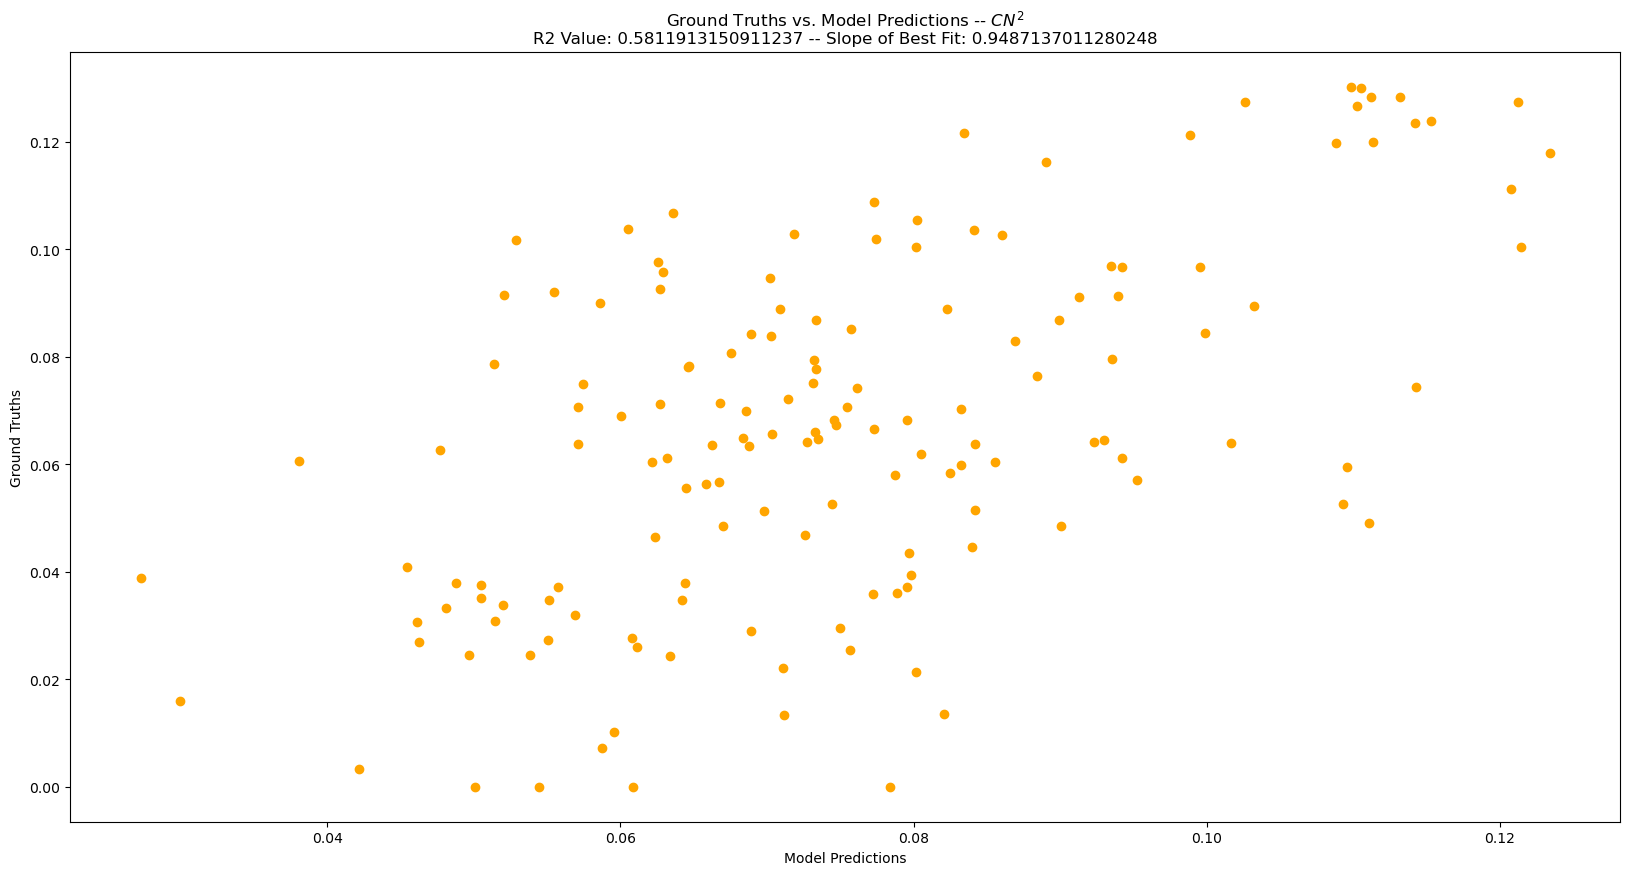

In [61]:
# Compute R2 value

slope_cn, intercept_cn, r_value_cn, p_value_cn, std_err_cn = stats.linregress(Cn2_pred, Cn2_true)

print("Results on training data")
print(f"Slope:{slope_cn}, intercept:{intercept_cn}, r_value:{r_value_cn}")

#slope_r0, intercept_r0, r_value_r0, p_value_r0, std_err_r0 = stats.linregress(r0_pred, r0_true)

#print("Results on training data")
#print(f"Slope:{slope_r0}, intercept:{intercept_r0}, r_value:{r_value_r0}")

fig, ax = plt.subplots(1,1, figsize=(20,10))


ax.scatter(Cn2_pred, Cn2_true, color='orange')
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Ground Truths')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title(f'Ground Truths vs. Model Predictions -- $CN^{2}$\nR2 Value: {r_value_cn} -- Slope of Best Fit: {slope_cn}')



#plt.savefig(f'R2Plots/{model_direc}.png', bbox_inches='tight')